<a href="https://colab.research.google.com/github/HeatherAnnFoster/Project-1--Revisited/blob/main/Regression_Prediction_of_Grocery_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
from numpy.lib.function_base import mean
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config (display = 'diagram')

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [80]:
path = '/content/sales_predictions.xlsx'
df = pd.read_excel(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


*This information show that in the Item Fat Content column, there are 5 different value names.  This will inconsistency will be fixed to show 'Low Fat' and 'Regular' names.*

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Data Cleaning**

This information shows thatin the Item Fat Content column, there ar e5 different value names.  This inconsistency will be fixed  to show 'Low Fat' and 'Regular' names.

In [82]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [83]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace("low fat")
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg')
df['Item_Fat_Content'].value_counts()

Low Fat    5423
Regular    3100
Name: Item_Fat_Content, dtype: int64

In [84]:
df.duplicated().sum()

0

*There are two columns that have missing values.  The Item Weight column is missng 1,463 values, which is 17.17% of its values.  The Outlet Size column is missing 2,410 values, which is 28.27% of its values.  Deleting these columns would skew the results of the preprocessing, so they will be adjusted during the pipeline phase of this analysis.*

In [85]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [86]:
df.shape

(8523, 12)

*The Item Identifier column was dropped.  It was irrelevant to this data set and the analysis.*

In [87]:
df = df.drop(columns = 'Item_Identifier')

In [88]:
df2 = df.copy()
df2

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


*The target for the data is the "Item Outlet Sales" column.  The rest of the information will be kept in the X section of the data.*

In [89]:
y = df['Item_Outlet_Sales']

In [90]:
X = df.drop(columns = 'Item_Outlet_Sales')

*The data is being split here.  The target, or y is Item Outlet Sales.*

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

*The data is put through the prepocessing object to get the data ready for modeling.  The selectors and columns are defined and ready for the machine learning to work properly.*

In [92]:
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')
mean_imputer = SimpleImputer(strategy = 'mean')
scaler = StandardScaler()
frequency_imputer = SimpleImputer(strategy = 'most_frequent')
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)
print('numeric columns are', num_columns)
print('categorical columns are', cat_columns)

numeric columns are ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
categorical columns are ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


*This is where the preprocessor comes into play.  The numeric and categorical pipelines take in the data, clean it and prepare it for modeling.*

In [93]:
numeric_pipeline = make_pipeline(mean_imputer, scaler)
numeric_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [94]:
categorical_pipeline = make_pipeline(frequency_imputer, ohe)
categorical_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

*Here, we will fit the dataset into the transformer and fill in the missing values.*

In [95]:
num_tuple = (numeric_pipeline, num_selector)
cat_tuple = (categorical_pipeline, cat_selector)

In [96]:
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])

In [97]:
preprocessor = make_column_transformer (num_tuple, cat_tuple)
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])

*Now, we will double check the dataset to make certain that the imputation is correct.*

In [98]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [99]:
print(X_train_processed)

[[ 0.81724868 -0.71277507  1.82810922 ...  0.          1.
   0.        ]
 [ 0.5563395  -1.29105225  0.60336888 ...  0.          1.
   0.        ]
 [-0.13151196  1.81331864  0.24454056 ...  1.          0.
   0.        ]
 ...
 [ 1.11373638 -0.92052713  1.52302674 ...  1.          0.
   0.        ]
 [ 1.76600931 -0.2277552  -0.38377708 ...  1.          0.
   0.        ]
 [ 0.81724868 -0.95867683 -0.73836105 ...  1.          0.
   0.        ]]


*Below is the pipeline needed for the data set.  This will take the data set and get it ready for predictions.*

In [100]:
linreg = LinearRegression()
linreg_pipe_1 = make_pipeline(preprocessor, linreg)
linreg_pipe_1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])),
                ('linearregression', LinearRegression())])

*Here the data set was fit into the preprocessor to get it ready to predict the sales profits.*

In [101]:
linreg_pipe_1.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])),
                ('linearregression', LinearRegression())])

*This prediction was made and shows a massive deviation in the training and testing models of the data set.*

In [102]:
training_predictions = linreg_pipe_1.predict(X_train)
testing_predictions = linreg_pipe_1.predict(X_test)
training_predictions[:10]

array([3808.  , 2650.  , 2610.25, 1482.75, 1875.25,  -70.  , 1591.25,
       5652.  , 4200.75, 2046.25])

In [103]:
y_train.head(10)

4776     515.3292
7510    3056.0220
5828    1577.9460
5327    1331.6000
4810    1687.1372
4377     111.8544
2280    1151.1682
8198    3401.5722
7514    3570.0196
3463    1523.3504
Name: Item_Outlet_Sales, dtype: float64

*This model is showing what the r2 or coefficient of determination.  This model shows the perentage of the variation in the target.*

In [104]:
train_r2 = np.corrcoef(y_train, training_predictions)[0][1]**2
test_r2 = np.corrcoef(y_test, testing_predictions)[0][1]**2
print(f'Model Training R2:{train_r2}')
print(f'Model Testing R2:{test_r2}')

Model Training R2:0.5615533291462604
Model Testing R2:0.5679379310902388


*This model is the Root Mean Squared Error model.  It is showing data that is positive.  It also shows there is a massive gap between the two scores.*

In [105]:
train_RMSE = np.sqrt(np.mean(np.abs(training_predictions-y_train)**2))
test_RMSE = np.sqrt(np.mean(np.abs(testing_predictions-y_test)**2))
print(f'Model Training RMSE:{train_RMSE}')
print(f'Model Testing RMSE:{test_RMSE}')

Model Training RMSE:1139.1065723592649
Model Testing RMSE:1092.7458279520458


In [106]:
train_MAE = np.mean(np.abs(training_predictions-y_train))

*The following is a decision tree model.  It shows the data is positively coorelated to each other, but there is a big gap between the scores.*

In [107]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
dec_tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [108]:
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [109]:
training_predictions = dec_tree_pipe.predict(X_train)
training_predictions = dec_tree_pipe.predict(X_test)
training_predictions[:10]

array([ 792.302 , 1366.2216,  784.3124, 3691.1952, 2570.6538,  732.38  ,
       5303.097 ,  850.8924, 1704.448 , 2926.191 ])

In [110]:
train_score = dec_tree_pipe.score (X_train, y_train)
test_score = dec_tree_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
0.185677307686953


*In the code boxes below, the information for the Decision Tree was put through a loop that would take the information and determine which model would work best for the company.  As the box with the scores shows, the model that would work the best is the Decision Tree with 5 columns because the test score was around 59%.  That means there are some errors, but they can be overlooked for the good of the sales.*

In [111]:
depths = list(range(2,12))
scores = pd.DataFrame(index = depths, columns = ["train_score", "test_score"])

In [112]:
for depth in depths:
  DT1 = DecisionTreeRegressor(max_depth = depth, random_state= 42)
  DT1.fit(X_train_processed, y_train)
  train_score = DT1.score(X_train_processed, y_train)
  test_score = DT1.score (X_test_processed, y_test)
  scores.loc[depth, "train_score"] = train_score
  scores.loc[depth, "test_score"] = test_score

In [113]:
scores.sort_values(by = "test_score", ascending = False).head()

,train_score,test_score
5,0.603934,0.59472
6,0.61499,0.584662
4,0.582625,0.584005
7,0.627178,0.5785
8,0.644066,0.557719


**Decision Tree**

In [114]:
dec_tree2 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree2_pipe = make_pipeline(preprocessor, dec_tree2)
dec_tree2_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [115]:
dec_tree2_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df4885b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df489360>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [116]:
training_predictions = dec_tree2_pipe.predict(X_train)
testing_predictions = dec_tree2_pipe.predict(X_test)
training_predictions[:10]

array([4055.65012805, 3008.58568342, 2516.85180062, 1512.48967824,
       2023.02155059,  243.51140594, 1512.48967824, 6490.04510959,
       4055.65012805, 2023.02155059])

In [117]:
train_MAE_score = mean_absolute_error(y_train, training_predictions)
test_MAE_score = mean_absolute_error(y_test, testing_predictions)
print(train_MAE_score)
print(test_MAE_score)

762.6528990243431
738.2513827382926


In [118]:
train_RMSE_score = np.sqrt(mean_squared_error(y_train, training_predictions))
test_RMSE_score = np.sqrt(mean_squared_error(y_test, testing_predictions))
print(train_RMSE_score)
print(test_RMSE_score)

1082.65354951864
1057.4302388040392


# Revisiting the Project 1

# Imports and Libraries

In [119]:
#set text displays for sk learn
from sklearn import set_config
set_config(display = 'text')
set_config(display='diagram')

# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Models and evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# Setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

# Set pandas to display more columns
pd.set_option('display.max_columns', 50)

# Load and Read the Data

In [120]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


# **Functions Needed for this Dataset**

In [121]:
def evaluate_regression(model, X_train_df2,y_train_df2, X_test_df2, y_test_df2):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""

    ## Training Data
    y_pred_train = model.predict(X_train_df2)
    r2_train = metrics.r2_score(y_train_df2, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train_df2, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test_df2)
    r2_test = metrics.r2_score(y_test_df2, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test_df2, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [122]:
+df#for plotting coeffs
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [123]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

##**Cleaning Up Data**

In [124]:
# Replace inconsistent categories
fat_content_map = {'LF':'Low Fat',
                   'reg':'Regular',
                   'low fat':'Low Fat'}
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace(fat_content_map)
## Verify
df2['Item_Fat_Content'].value_counts()

Low Fat    5423
Regular    3100
Name: Item_Fat_Content, dtype: int64

#**X and y Variables and Train_Test_Split**

In [125]:
## Make the X and y variables
y = df2['Item_Outlet_Sales'].copy()
X = df2.drop(columns=['Item_Outlet_Sales', 'Outlet_Identifier']).copy()

## Create the train-test-split with random state for reproducibility
X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(X, y, random_state=42)

#**Preprocessor**

In [148]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple,
                                       remainder='passthrough',
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df2f8e50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa4df2f89a0>)],
                  verbose_feature_names_out=False)

#**Transforming the Data**

In [127]:
# Fit the ColumnTransformer called 'preprocessor' on the training data.

# Fit the preprocessor
preprocessor.fit(X_train_df2)
feature_names = preprocessor.get_feature_names_out()

# Transform train and test
X_train_df2_processed = preprocessor.transform(X_train_df2)
X_test_df2_processed = preprocessor.transform(X_test_df2)

# Get the column names
cols = preprocessor.get_feature_names_out()

# View the transformations
X_train_df2 = pd.DataFrame(X_train_df2_processed, columns=cols)
X_test_df2 = pd.DataFrame(X_test_df2_processed, columns=cols)
X_test_df2

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,3.310089e-01,-0.776646,-0.998816,-1.293807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.179892e+00,0.100317,-1.585194,-0.102145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.784469e-01,-0.482994,-1.595784,0.136187,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.213344e-16,-0.415440,0.506592,-1.532139,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-6.426567e-01,-1.047426,0.886725,0.732018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,1.113736e+00,-1.134688,0.473646,-1.293807,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2127,-6.426567e-01,-1.291052,0.018124,1.089517,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2128,-1.139570e+00,1.218324,1.093980,0.493686,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2129,-1.497727e+00,-0.778096,-0.366800,0.136187,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [128]:
y_test_df2.head()

7503    1743.0644
2957     356.8688
7031     377.5086
1084    5778.4782
856     2356.9320
Name: Item_Outlet_Sales, dtype: float64

#**Model 1: Linear Regression**

Fit and evalutate your Linear Regression model using your dataframe X_train and X_test data.

In [129]:
# Apply the linear regression and display coefficients using the pre-defined function
lin_reg= LinearRegression(fit_intercept = False)
lin_reg.fit(X_train_df2,y_train_df2)

LinearRegression(fit_intercept=False)

In [130]:
evaluate_regression(lin_reg, X_train_df2, y_train_df2,
                    X_test_df2, y_test_df2)

Training Data:	R^2= 0.56	RMSE= 1139.59
Test Data:	R^2= 0.57	RMSE= 1092.83


## **Linear Regression Model**

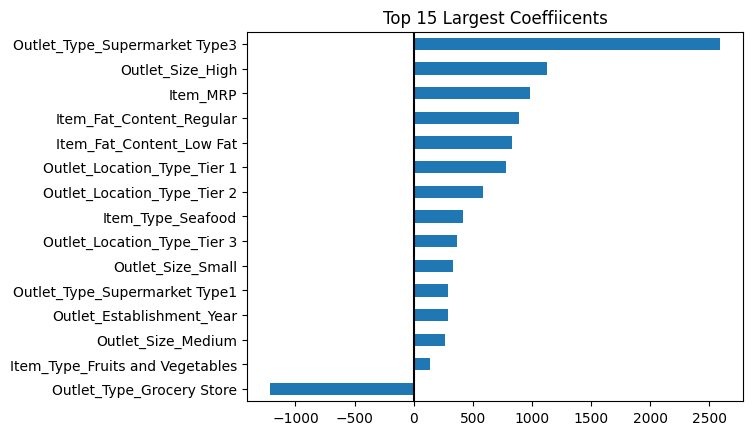

In [131]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_

# Rank the coeffs and select the top_n
top_n = 15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()

# Plot the coefficients and save the model
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');
plt.savefig('lin-reg.png')

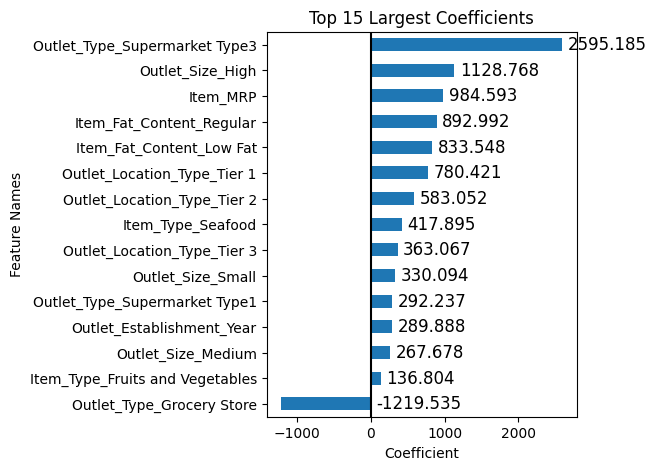

In [132]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

## **Linear Regression Model**

Top 3 Most Impactful Features

1.  Outlet_Type_Supermarket_Type3
2.  Outlet_Size_High
3.  Item_MRP

Interpretation of the Coefficients

1.  The size of the outlet is important to the sales of the groceries.  It increases their sales by 2,595.185.

2.  The amount of customers is important to the sales of the groceries.  It increases their sales by 1128.768.

3.  The Item_MRP increases the sales of the groceries by 984.593.

#**Model 2: Decision Tree Regression**

Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.

In [133]:
# Fit and train the data.
dec_tree= DecisionTreeRegressor()
dec_tree.fit(X_train_df2,y_train_df2)

DecisionTreeRegressor()

In [134]:
evaluate_regression(dec_tree, X_train_df2, y_train_df2, X_test_df2,y_test_df2)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.20	RMSE= 1481.90


## **Extract and visualize the coefficients that your model determined.**

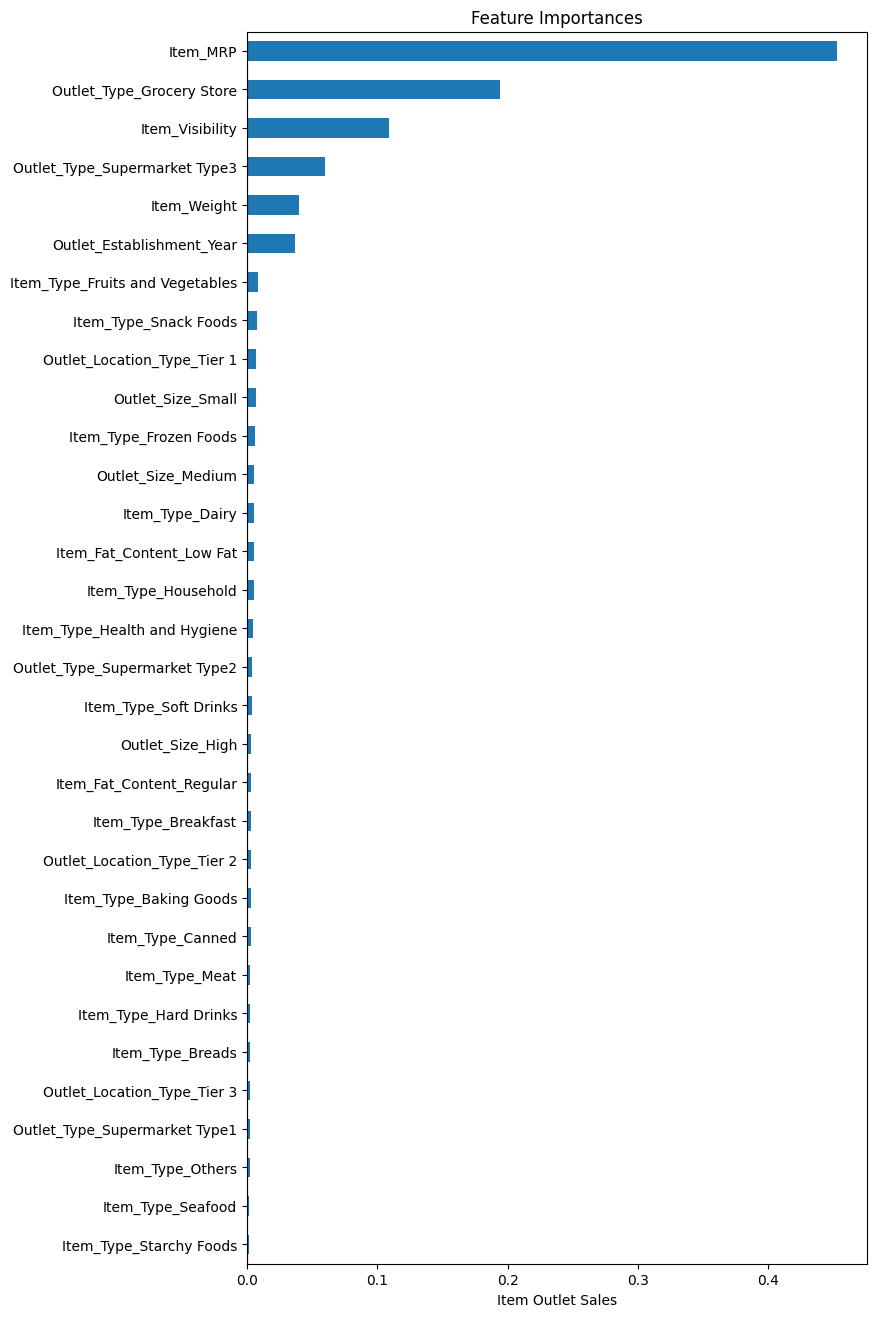

In [145]:
# Create model and save
coeffs = pd.Series(dec_tree.feature_importances_, index=feature_names,
                        name='Feature Importances')
## Plot everything but outlet identifier
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Feature Importances");
plt.savefig('dec-tree.png')

## **Identify the top 5 most important features.**

1.  Item_MRP

2.  Outlet_Type_Grocery_Store

3.  Item_Visibility

4.  Outlet_Type_Supermartet_3

5.  Item_Weight

# **Modeling 3: Tuned Decision Tree Regression**
I kept the default decision tree because I wanted to see if tuning it would give a different assessemnt of the data.

In [139]:
# What was the depth of the default tree?
dec_tree.get_depth()

40

In [149]:
# Try the loops through 2 and 40 and see which depth would give the best score
depths= list(range(2, 42))
scores = pd.DataFrame(index=depths, columns=["Test Score","Train Score"])

for depth in depths:
  dec_tree=DecisionTreeRegressor(max_depth=depth, random_state=42)
  dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
  dec_tree_pipe.fit(X_train_df2, y_train_df2)
  train_score=dec_tree_pipe.score(X_train_df2, y_train_df2)
  test_score=dec_tree_pipe.score(X_test_df2, y_test_df2)
  scores.loc[depth, "Train Score"] = train_score
  scores.loc[depth, "Test Score"] = test_score

,Test Score,Train Score
5,0.59472,0.603934
4,0.584005,0.582625
6,0.58098,0.614979
7,0.574537,0.627557
8,0.55474,0.645211


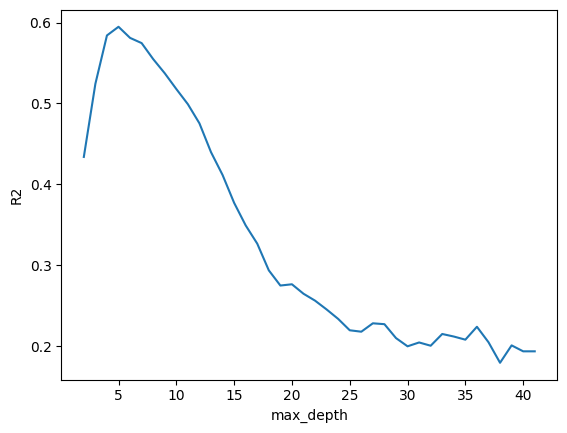

In [150]:
# Plot the model
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

# Which max_depth gives the best score?
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

## **Model Interpretation**

This model shows that the best depth to use is 5 because it has the highest R squared score.  So, in the following analysis, the max depth that will be used is 5.

##  **Extract and visualize the coefficients that the model determined.**

In [151]:
# Fit the data
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_df2,y_train_df2)
evaluate_regression(dec_tree_5, X_train_df2, y_train_df2, X_test_df2,y_test_df2)

Training Data:	R^2= 0.60	RMSE= 1082.65
Test Data:	R^2= 0.59	RMSE= 1057.43


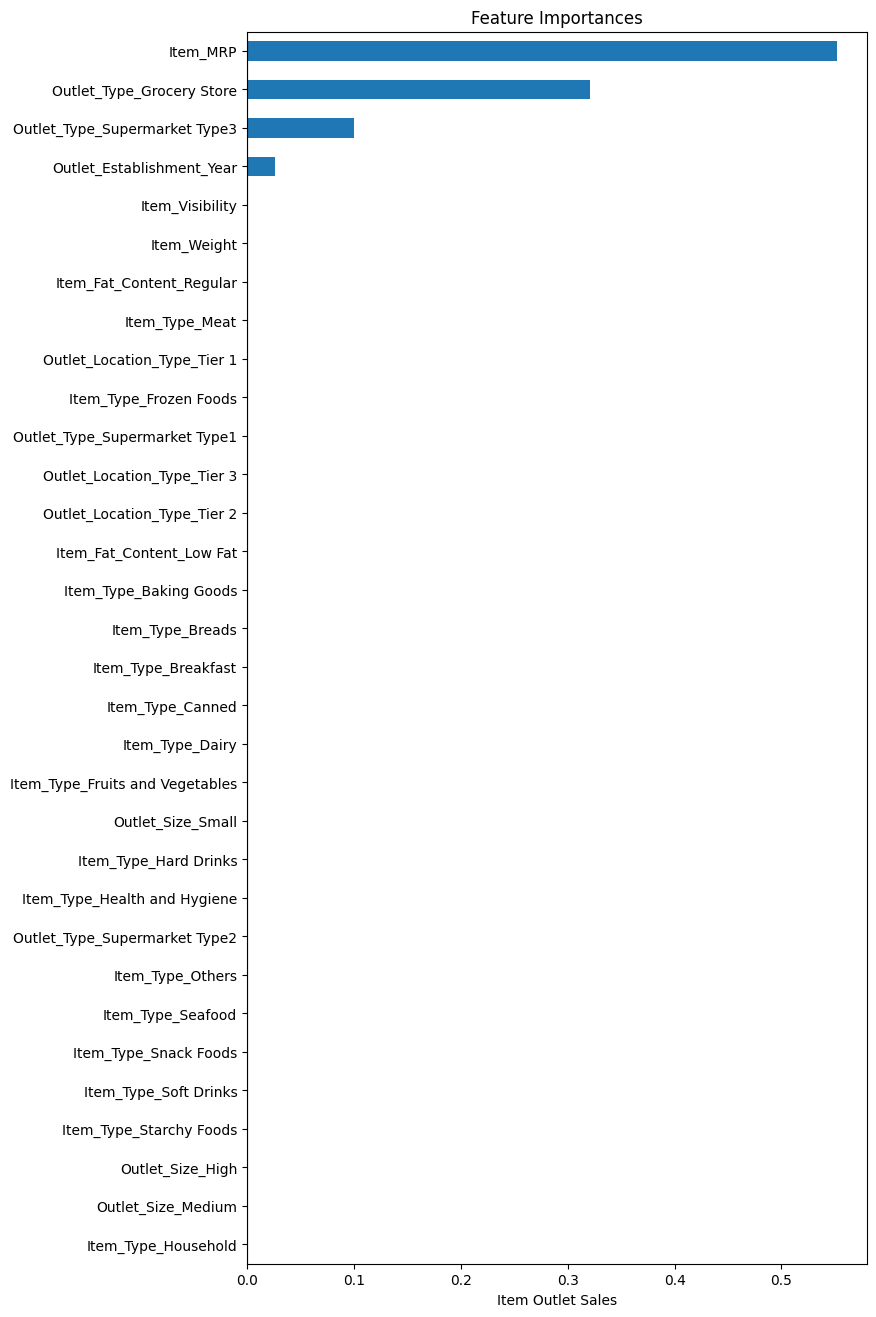

In [143]:
# Crate and plot the model
coeffs = pd.Series(dec_tree_5.feature_importances_, index=feature_names,
                        name='Feature Importances')
## Plot everything but outlet identifier
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Feature Importances");
plt.savefig('tuned_dec-tree.png')

## **Identify the top 5 most important features.**

1.  Item_MPR

2.  Outlet_Type_Grocery_Store

3.  Outlet_Type_Supermarket_Type3

4.  Outlet Establishment_Year

5.  Item_Visibility

#**Serialize Your Best Models with Joblib**

In [147]:
export = {'preprocessor': preprocessor,
          'X_train':X_train_df2,
          'y_train': y_train_df2,
          'X_test':X_test_df2,
          'y_test': y_test_df2,
          'DecisionTreeRegressor': dec_tree_5 }
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']